In [505]:
# Import required libraries
import numpy as np
import pandas as pd
import re
import random

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder


from xgboost import XGBRegressor
import xgboost as xgb


import matplotlib.pyplot as plt

In [468]:
RANDOM_STATE = 123 #35

In [469]:
df = pd.read_csv('train.csv', delimiter=',')
df.pop('id')
df.shape

(188533, 12)

In [470]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [471]:
# Check for missing values
print(f'missing data: {df.isnull().sum()}')

missing data: brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


In [472]:
# Make price and milage float to treat them as continuos features
df['price']=df['price'].astype('float')
df['milage'] = df['milage'].astype('float')

In [473]:
# Cleans the categorical and continuos data
class Cleaner():
    def __init__(self, df):
      self.df = df
      self.categoricals = []
      self.continuos = []
      self.categoricals_imputed = []
      self.continuos_imputed = []

      self.mean_imputer = SimpleImputer(strategy='mean')
      self.mode_imputer = SimpleImputer(strategy='most_frequent')

      self.update_vars()

    def update_vars(self, e_categoricals=[], e_continuos=[]):
        '''
        Updates list of categoricals and continuos variables based on dtypes
        Features with dtype int, object and category are considered categoricals while float features are considered continuos.

        Args:
        e_categoricals (list): Features that are not categories but be placed as categoricals
        e_continuos (list) :  Features that are not continuos but be placed as continuos
        '''
        self.categoricals = list(set(self.categoricals) | set(self.df.select_dtypes(include=[int, object, 'category']).columns))

        if e_categoricals:
            self.categoricals = list(set(self.categoricals) | set(e_categoricals))

        self.continuos = [col for col in self.df.columns if col not in self.categoricals]
        if e_continuos:
            self.continuos = list(set(self.continuos) | set(e_continuos))

    def clean_categoricals(self):
        self.update_vars()
        categorical_missing_vars = list(filter(lambda x: x not in self.categoricals_imputed, self.categoricals))

        print(f'categorical_missing_vars: {categorical_missing_vars}')

        self.df[categorical_missing_vars] = self.mode_imputer.fit_transform(self.df[categorical_missing_vars])
        self.categoricals_imputed += categorical_missing_vars

        return self.df

    def clean_continuos(self):
        self.update_vars()
        continuos_missing_vars = list(filter(lambda x: x not in self.continuos_imputed, self.continuos))

        print(f'continuos_missing_vars: {continuos_missing_vars}')

        self.df[continuos_missing_vars] = self.mean_imputer.fit_transform(self.df[continuos_missing_vars])
        self.continuos_imputed += continuos_missing_vars

        return self.df

In [474]:
cleaner = Cleaner(df = df)
cleaner.clean_categoricals()
df.isnull().sum()

categorical_missing_vars: ['transmission', 'model', 'clean_title', 'int_col', 'brand', 'model_year', 'accident', 'ext_col', 'fuel_type', 'engine']


,0
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


In [475]:
# Categorical: Int, object: Won't be scaled and will be applied mode Imputer
# Continuos: Float, float64:  Will be Scaled, applied mean Imputer

# Feature Engineering

Functions to extract features from original dataset

In [476]:
# Categorical
def get_automatic(string):
    string = string.lower()
    if 'a/t' in string or 'automatic' in string or 'at' in string:
        return 1
    else:
        return 0

In [477]:
# Categorical
def get_gears(string):
    match = re.search(r'^(\d+)-Speed', string, re.IGNORECASE)
    if match:
        gears = match.group(1)
        return int(gears)
    else:
        return None

In [478]:
# Contiunuos
def get_hp(engine):
    match = re.search(r'([\d.]+)HP', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [479]:
# Continuos
def get_L(engine):
    match = re.search(r'([\d.]+)L', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [480]:
# Categorical
def get_cyl(engine):
    match = re.search(r'([\d.]+)?\s?(?:Cylinder|Cyl|Cylinders)', engine, re.IGNORECASE)
    if match:
      return int(match.group(1))
    else:
      return None

In [481]:
# Categorical
def is_electric(engine):
    if 'electric' in engine.lower():
      return 1
    else:
      return 0

In [482]:
# Continuos
def num_valves(engine):
    match = re.search(r'([\d+])V', engine)
    if match:
      return float(match.group(1))
    else:
      return None

In [483]:
# Categorical
def is_accident(accident):
    if type(accident) == str:
        if 'accident' in accident.lower():
          return 1
        else:
          return 0
    else:
        return None

Functions to extract featurs

In [484]:
# Create features and insert into dataframe

def create_features(df):
    ''' Returns dataframe with newly created features '''
    df['automatic'] = df['transmission'].apply(get_automatic)
    df['gears'] = df['transmission'].apply(get_gears)
    df['hp'] = df['engine'].apply(get_hp)
    df['L'] = df['engine'].apply(get_L)
    df['cylinders'] = df['engine'].apply(get_cyl)
    df['accident'] = df['accident'].apply(is_accident)
    df['electric'] = df['engine'].apply(is_electric)
    df['valves'] = df['engine'].apply(num_valves)
    return df

def create_interactions(df):
    ''' Returns dataframe with newly created interaction features'''
    df['hp/l'] = np.where(df['L'] != 0, df['hp'] / df['L'], None).astype('float')
    df['mil/l'] = np.where(df['L'] != 0, df['milage'] / df['L'], None).astype('float')
    df['mil/hp'] = np.where(df['hp'] != 0, df['milage'] / df['hp'], None).astype('float')
    df['l/cyl'] = np.where(df['cylinders'] != 0, df['L'] / df['cylinders'], None).astype('float')
    df['hp/gears'] = np.where(df['gears'] != 0, df['hp'] / df['gears'], None).astype('float')
    df['mil/gears'] = np.where(df['gears'] != 0, df['milage'] / df['gears'], None).astype('float')
    df['mil/cyl'] = np.where(df['cylinders'] != 0, df['milage'] / df['cylinders'], None).astype('float')

    df['hp*automatic'] = df['hp'] * df['automatic']
    df['cyl*gears'] = df['cylinders'] * df['gears']

    df['carAge'] = pd.Series(2024 - df['model_year']).astype('int')
    df['mil/year'] = np.where(df['carAge'] != 0, df['milage'] / df['carAge'], None).astype('float')
    df['hp*accident'] = pd.Series(df['hp'] * df['accident']).astype('float')
    df['accident*carAge'] = pd.Series(df['accident'] * df['carAge']).astype('float')
    df['acc*milage'] = pd.Series(df['accident'] * df['milage']).astype('float')

    df['mil*carAge'] = pd.Series(df['milage'] * df['carAge']).astype('float')
    df['hp*mil'] = pd.Series(df['hp'] * df['milage']).astype('float')
    return df

In [485]:
df = create_features(df)

In [486]:
# We will treat some suitable variables as categorical
cleaner.update_vars(e_categoricals = ['L', 'cylinders', 'gears'])

### Treat missing values of variables

In [488]:
print(df.isnull().sum())

brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears            84434
hp               33259
L                14214
cylinders        37855
electric             0
valves          165115
dtype: int64


In [489]:
cleaner.clean_categoricals()
cleaner.clean_continuos()
df.isnull().sum()

categorical_missing_vars: ['gears', 'cylinders', 'automatic', 'L', 'electric']
continuos_missing_vars: ['milage', 'price', 'hp', 'valves']


,0
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


### Create Interaction features

In [490]:
# Create interaction features
df = create_interactions(df)

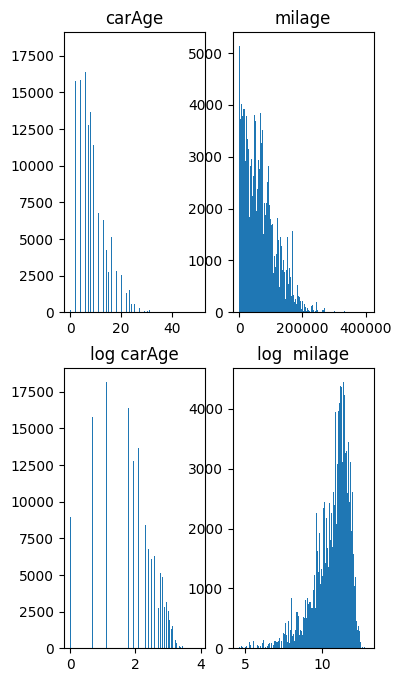

In [491]:
# Some features with rghtly skewed data can be log transformed

fig, axs = plt.subplots(2, 2, figsize=(4, 8))

# carAge distribution
axs[0, 0].hist(df['carAge'], bins=200)
axs[0, 0].set_title('carAge')

axs[0, 1].hist(df['milage'], bins=200)
axs[0, 1].set_title('milage')

# milage is right skewed. Log transformation could be used.
carAge = np.where(df['carAge'] != 0, df['carAge'], 1).astype('float')
milage = np.where(df['milage'] != 0, df['milage'], 1).astype('float')

log_carAge = np.log(carAge)
log_milage = np.log(milage)

axs[1, 0].hist(log_carAge, bins=200)
axs[1, 0].set_title('log carAge')

axs[1,1].hist(log_milage, bins=200,)
axs[1,1].set_title('log  milage')
plt.show()

In [492]:
# Add binning to milage and categorize ordinally

# Get range of values
print(np.min(df['milage']), np.max(df['milage']))

bins = [99.0, 1000.0, 10000.0, 50000.0, 100000.0, 300000.0, 500000.0]

binned_milage = pd.cut(df['milage'], bins, right=False)

# mils_bins_category is dict of structure {interval: int} where int is increasing from 0 to 5: there are 6 Intervals
mils_bins_category = {}
for i in range(0, len(bins) - 1, 1):
    mils_bins_category[pd.Interval(bins[i], bins[i+1], closed='left')] = i

100.0 405000.0


In [493]:
# Assign classes to brands according to their mean prices
# Classes are of type int, ordinally categorized

# Get range of values
print(np.min(df['price']), np.max(df['price']))

bins = [1000.0, 5000.0, 10000.0, 25000.0, 50000.0, 100000.0, 150000.0, 200000.0, 250000.0, 300000.0]

binned_prices = pd.cut(df['price'], bins, right=False) # 9 Intervals

# Create bins category mapping
bins_category = {pd.Interval(bins[i], bins[i+1], closed='left'): i for i in range(len(bins) - 1)}

# Create dict {'brand_name' : mean_price}
brand_avg_price = df.groupby('brand')['price'].mean().to_dict()


def get_class(mprice):
    ''' Returns category of mean price
    Args:
    mprice(float) : Mean price
    Returns:
    category(int): Category of interval in which mrice lies
    '''

    for interval, category in bins_category.items():
        if mprice in interval:
          return category

2000.0 2954083.0


In [494]:
def additional_features(df):
    df['AverageMilage'] = df.groupby("brand")['milage'].transform('mean')
    df['BrandFreq'] = df.groupby('brand')['brand'].transform('count')/df['brand'].count()

    brand_count = df.groupby('brand')['brand'].count().to_dict() #{'brand_name' : mean_price}
    df['brand_count'] = df['brand'].map(brand_count)

    brand_avg_mil = df.groupby('brand')['milage'].mean().to_dict() #{'brand_name' : mean_price}
    df['brand_avg_mil'] = df['brand'].map(brand_avg_mil)

    df['binned_milage'] = binned_milage.map(lambda x: mils_bins_category[x])

    brand_class = {brand: get_class(price) for brand, price in brand_avg_price.items()}
    df['brand_class'] = df['brand'].map(lambda x: brand_class[x])

    df['log_milage'] = np.log(df['milage'])

    df['logL'] = np.log(df['L'])

    df['logAge'] = np.log1p(df['carAge'])


    return df

In [495]:
df = additional_features(df)

In [496]:
cleaner.clean_continuos()

continuos_missing_vars: ['hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge']


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,hp*mil,AverageMilage,BrandFreq,brand_count,brand_avg_mil,binned_milage,brand_class,log_milage,logL,logAge
0,MINI,Cooper S Base,2007,213000.0,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,0,...,3.663600e+07,93577.359023,0.005644,1064,93577.359023,4,2,12.269047,0.470004,2.890372
1,Lincoln,LS V8,2002,143250.0,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,1,...,3.609900e+07,79220.015270,0.012852,2423,79220.015270,4,3,11.872347,1.360977,3.135494
2,Chevrolet,Silverado 2500 LT,2002,136731.0,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,0,...,4.375392e+07,68920.846281,0.086643,16335,68920.846281,4,3,11.825771,1.667707,3.135494
3,Genesis,G90 5.0 Ultimate,2017,19500.0,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,0,...,8.190000e+06,37865.789474,0.005140,969,37865.789474,2,4,9.878170,1.609438,2.079442
4,Mercedes-Benz,Metris Base,2021,7388.0,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,0,...,1.536704e+06,54796.432036,0.101690,19172,54796.432036,1,4,8.907612,0.693147,1.386294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,Escalade ESV Platinum,2017,49000.0,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,0,...,2.058000e+07,70207.694480,0.024791,4674,70207.694480,2,3,10.799576,1.824549,2.079442
188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600.0,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,1,...,1.101100e+07,54796.432036,0.101690,19172,54796.432036,2,4,10.261162,1.098612,1.945910
188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650.0,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,0,...,6.401850e+06,54796.432036,0.101690,19172,54796.432036,2,4,9.521495,1.386294,1.386294
188531,Audi,S5 3.0T Prestige,2022,13895.0,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,0,...,4.769651e+06,59147.556903,0.057746,10887,59147.556903,2,3,9.539284,1.098612,1.098612


In [497]:
# Label categorical features
for colname in cleaner.categoricals:
    df[colname], _ = df[colname].factorize()

In [498]:
X = df.copy()
y = X.pop('price')

#### PCA

In [499]:
# Standardize the data (important for PCA)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X.select_dtypes(include='float'))
print(X.shape)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_components = pca.fit_transform(X_scaled)

# Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print("Explained Variance Ratio:", explained_variance)

# Convert to DataFrame for better readability
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
X = pd.concat([X, pca_df], axis=1)

(188533, 43)
Explained Variance Ratio: 0.4995459781364915


In [500]:
cleaner.categoricals.extend(['PC1', 'PC2'])

#### K-means Clustering

In [501]:
# Add cluster feature
c_scaler = StandardScaler()
XC = [col for col in X.columns if col not in cleaner.categoricals]
XC = X[XC]
XC = c_scaler.fit_transform(XC)

# Create cluster feature
kmeans = KMeans(n_clusters=3, n_init=10)
X['Cluster'] = kmeans.fit_predict(XC)
X['Cluster'] = X['Cluster'].astype('category')

In [502]:
cleaner.categoricals.extend(['Cluster'])

#### Output of a trained Ridge model as a feature

In [503]:
r_model = Ridge(alpha=1)
r_model.fit(X, y)
np.sqrt(mean_squared_error(r_model.predict(X), y))
X['r_predict'] = r_model.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.44565e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [504]:
cols = ['model', 'fuel_type', 'brand', 'int_col', 'ext_col', 'transmission', 'brand_class', 'Cluster',]

# One-hot encoding
encoded_data = pd.get_dummies(X[cols].astype('str'))
X = pd.concat([X, encoded_data], axis=1)

# Remove original encoded features
X = X.drop(cols, axis=1)

# Update categoricals list in cleaner
cleaner.categoricals = [col for col in cleaner.categoricals if col not in cols]
cleaner.categoricals.extend(encoded_data.columns.tolist())
len(cleaner.categoricals)

2510

# Features selection

In [506]:
params = {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}

In [507]:
# Evaluates model
def get_error(model, x_train, x_cv, y_train, y_cv, print_mse=True):
    ypred = model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    xgb_train_mse = np.sqrt(xgb_train_mse)

    ypred = model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    xgb_cv_mse = np.sqrt(xgb_cv_mse)

    if print_mse:
        print(f'train MSE: {xgb_train_mse}\nValidation MSE: {xgb_cv_mse}')
        print(f'Difference: {abs(xgb_train_mse - xgb_cv_mse):.4f}')

    return xgb_train_mse, xgb_cv_mse


In [508]:
# Choose features to use based on MI score
def run_model(X, y, selected_features):
    '''
    Runs selected features on model, returns and plots training and validation MSEs
    '''
    train_mse = []
    val_mse = []
    m, n = X.shape

    N = range(1, len(selected_features))

    for n in N:
        x = X[selected_features[:n]]

        x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE)

        # Scale Training data
        scaler1 = StandardScaler()
        x_train = scaler1.fit_transform(x_train)
        x_cv = scaler1.transform(x_cv)

        model = XGBRegressor(learning_rate= 0.2,
                        max_depth = 2,
                        n_estimators = 200,)
        model.fit(x_train, y_train)

        ypred = model.predict(x_train)
        xgb_train_mse = mean_squared_error(y_train, ypred)
        train_mse.append(np.sqrt(xgb_train_mse))

        ypred = model.predict(x_cv)
        xgb_cv_mse = mean_squared_error(y_cv, ypred)
        val_mse.append(np.sqrt(xgb_cv_mse))

    plt.close('all')
    plt.plot(N, train_mse, c='r', label='training MSE')
    plt.plot(N, val_mse, c='b', label='Val MSE')
    plt.xlabel('Number of features')
    plt.ylabel('MSEs')
    plt.legend()
    plt.show()

    return train_mse, val_mse, selected_features

In [509]:
'''# Randomly select 12 feature and evaluate model 20 times. Select Features that gives best results.
min_features = []
combinations = []
min_loss = 80000
for _ in range(20):
    t , v, s = run_model(X, y, random.sample(list(X.columns), 12))
    if v[np.argmin(v)] < min_loss:
        min_features = s
        min_loss = v[np.argmin(v)]
        combinations.append([min_loss, min_features])
        print(min_loss, min_features)'''

'# Randomly select 12 feature and evaluate model 20 times. Select Features that gives best results.\nmin_features = []\ncombinations = []\nmin_loss = 80000\nfor _ in range(20):\n    t , v, s = run_model(X, y, random.sample(list(X.columns), 12))\n    if v[np.argmin(v)] < min_loss:\n        min_features = s\n        min_loss = v[np.argmin(v)]\n        combinations.append([min_loss, min_features])\n        print(min_loss, min_features)'

In [510]:
# Some results of above code. First float is Val MSE
'''['mil/year', 'ext_col', 'mil*carAge', 'mil*carAge', 'transmission', 'f1', 'hp/l', 'PC2', 73296.43812571446],
[73162.98697036724, ['milage', 'AverageMilage', 'hp/l', 'transmission', 'hp', 'valves', 'hp*mil', 'acc*milage']]
73261.07209921598 ['f1', 'L', 'brand_count', 'brand_class', 'PC1', 'BrandFreq', 'automatic', 'hp']
73187.51937436737 ['f1', 'milage', 'brand_class', 'AverageMilage', 'gears', 'accident', 'transmission', 'binned_milage']
73176.84507175711 ['valves', 'clean_title', 'engine', 'accident*carAge', 'AverageMilage', 'PC2', 'f1', 'mil/l']
73162.98697036724 ['milage', 'AverageMilage', 'hp/l', 'transmission', 'hp', 'valves', 'hp*mil', 'acc*milage']
73336.56696737467 ['binned_milage', 'model_year', 'mil/gears', 'mil*carAge', 'hp/l', 'hp*mil', 'brand_count', 'mil/hp', 'mil/l', 'valves']
73168.71486431957 ['engine', 'cylinders', 'milage', 'transmission', 'mil/year', 'hp/l', 'ext_col', 'brand_avg_mil', 'acc*milage', 'accident']

73088.9196658275 ['mil/l', 'engine', 'transmission', 'BrandFreq', 'mil*carAge', 'L', 'PC1', 'hp', 'f1', 'engine', 'BrandFreq', 'milage']

73162.18700040436 ['cylinders', 'engine', 'clean_title', 'hp', 'model', 'mil*carAge', 'brand_count', 'brand_avg_mil', 'L', 'BrandFreq', 'ext_col', 'brand']

'''

"['mil/year', 'ext_col', 'mil*carAge', 'mil*carAge', 'transmission', 'f1', 'hp/l', 'PC2', 73296.43812571446],\n[73162.98697036724, ['milage', 'AverageMilage', 'hp/l', 'transmission', 'hp', 'valves', 'hp*mil', 'acc*milage']]\n73261.07209921598 ['f1', 'L', 'brand_count', 'brand_class', 'PC1', 'BrandFreq', 'automatic', 'hp']\n73187.51937436737 ['f1', 'milage', 'brand_class', 'AverageMilage', 'gears', 'accident', 'transmission', 'binned_milage']\n73176.84507175711 ['valves', 'clean_title', 'engine', 'accident*carAge', 'AverageMilage', 'PC2', 'f1', 'mil/l']\n73162.98697036724 ['milage', 'AverageMilage', 'hp/l', 'transmission', 'hp', 'valves', 'hp*mil', 'acc*milage']\n73336.56696737467 ['binned_milage', 'model_year', 'mil/gears', 'mil*carAge', 'hp/l', 'hp*mil', 'brand_count', 'mil/hp', 'mil/l', 'valves']\n73168.71486431957 ['engine', 'cylinders', 'milage', 'transmission', 'mil/year', 'hp/l', 'ext_col', 'brand_avg_mil', 'acc*milage', 'accident']\n\n73088.9196658275 ['mil/l', 'engine', 'transm

# Training

In [511]:
X_train = X
X_train.shape

(188533, 2535)

In [512]:
model = XGBRegressor(learning_rate= 0.2,
                     max_depth = 2,
                     n_estimators = 100,
                     enable_categorical=True,
                     subsample= 0.6,
                    colsample_bytree=0.8,
                    gamma = 0.1,
                    reg_alpha=0.01,
                    reg_lambda=1.5,
                     )

In [513]:
# Split dataset into training, validation and testing subsets
x_train, x_cv, y_train, y_cv = train_test_split(X_train, y, test_size=0.05, random_state=37)

print(x_train.shape, x_cv.shape)

(179106, 2535) (9427, 2535)


In [514]:
# Scale continuos features
continuos_features_to_scale = [col for col in x_train.columns if col not in cleaner.categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

scalerTrain = StandardScaler()
x_train = scalerTrain.fit_transform(x_train[continuos_features_to_scale])
x_cv = scalerTrain.transform(x_cv[continuos_features_to_scale])

Features to be scaled: ['milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge', 'r_predict']


In [515]:
# Train model
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [516]:
# Calculate RMSE
ypred = model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)
np.sqrt(xgb_train_mse)

72208.25513308863

In [518]:
# Evaluate model
_, _ = get_error(model, x_train, x_cv, y_train, y_cv)

train MSE: 72208.25513308863
Validation MSE: 80378.27359926506
Difference: 8170.0185


In [519]:
# Test on 10 random states 5 times and see the average
train_ave = []
cv_ave = []

for _ in range(5):
    train_mses = []
    cv_mses = []
    states = [random.randint(1, 1000) for _ in range(10)]

    for state in states:
        # Split dataset into training, validation and testing subsets
        x_train, x_cv, y_train, y_cv = train_test_split(X_train, y, test_size=0.05, random_state=state)

        print(x_train.shape, x_cv.shape)

        # Scale continuos features
        continuos_features_to_scale = [col for col in x_train.columns if col not in cleaner.categoricals]

        scalerTrain_ = StandardScaler()
        x_train = scalerTrain_.fit_transform(x_train[continuos_features_to_scale])
        x_cv = scalerTrain_.transform(x_cv[continuos_features_to_scale])

        model.fit(x_train, y_train)

        # Evaluate model
        train_mse, cv_mse = get_error(model, x_train, x_cv, y_train, y_cv, print_mse=False)
        train_mses.append(train_mse)
        cv_mses.append(cv_mse)

    train_ave.append(np.mean(train_mses))
    cv_ave.append(np.mean(cv_mses))

(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427, 2535)
(179106, 2535) (9427

In [520]:
print(np.mean(train_ave))
print(np.mean(cv_ave))

72583.69970001504
72557.15546632132


### Submission

In [566]:
test = pd.read_csv('test.csv')
id = test.pop('id')
test['milage'] = test['milage'].astype('float')

In [567]:
test_cleaner = Cleaner(df=test)
test_cleaner.clean_categoricals()
test = create_features(test)
test_cleaner.update_vars(e_categoricals = ['L', 'cylinders', 'gears'])
test_cleaner.clean_categoricals()
test_cleaner.clean_continuos()
test = create_interactions(test)
test = additional_features(test)
test = test_cleaner.clean_categoricals()
test = test_cleaner.clean_continuos()

categorical_missing_vars: ['transmission', 'model', 'clean_title', 'int_col', 'brand', 'model_year', 'accident', 'ext_col', 'fuel_type', 'engine']
categorical_missing_vars: ['gears', 'cylinders', 'automatic', 'L', 'electric']
continuos_missing_vars: ['milage', 'hp', 'valves']
categorical_missing_vars: ['brand_class', 'carAge', 'brand_count', 'binned_milage']
continuos_missing_vars: ['hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge']


In [568]:
for colname in test_cleaner.categoricals:
    test[colname], _ = test[colname].factorize()

In [569]:
test_scaled = scaler_pca.transform(test[test_cleaner.continuos])
pca_components = pca.transform(test_scaled)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
test = pd.concat([test, pca_df], axis=1)
test_cleaner.categoricals.extend(['PC1', 'PC2'])

In [570]:
#c_scaler = StandardScaler()
XC = [col for col in test.columns if col not in test_cleaner.categoricals]
XC = test[XC]
XC = c_scaler.transform(XC)

# Create cluster feature
#kmeans = KMeans(n_clusters=3, n_init=10)
test['Cluster'] = kmeans.fit_predict(XC)
test['Cluster'] = test['Cluster'].astype('category')
test_cleaner.categoricals.extend(['Cluster'])

In [571]:
# Get feature from Ridge model
test['r_predict'] = r_model.predict(test)

In [572]:
# One-hot encoding
test_encoded_data = pd.get_dummies(test[cols].astype('str'))
test = pd.concat([test, test_encoded_data], axis=1)

# Remove original encoded features
test = test.drop(cols, axis=1)

# Update categoricals list in cleaner
test_cleaner.categoricals = [col for col in test_cleaner.categoricals if col not in cols]
test_cleaner.categoricals.extend(test_encoded_data.columns.tolist())
len(test_cleaner.categoricals)

2500

In [573]:
test.shape

(125690, 2525)

In [577]:
continuos_features_to_scale = [col for col in test.columns if col not in test_cleaner.categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

x_test = scalerTrain.transform(test[continuos_features_to_scale])

Features to be scaled: ['milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge', 'r_predict']


In [582]:
pred = model.predict(x_test)

In [583]:
submision = pd.DataFrame({'id': id, 'price': pred})
submision.to_csv('submission.csv', index=False)

In [580]:
submision.head()

,id,price
0,188533,17720.927734
1,188534,59444.429688
2,188535,74351.515625
3,188536,29066.341797
4,188537,32051.820312


In [ ]:
# Thank You